# Investigating the Latent Space of a Variational Autoencoder 

An Autoencoder is a particular architecture of neural network that aims to provide a condensed representation of it's input data, for example condensing a 28 by 28 image down to a 5 dimensional representation. It typically does this by funneling it's input through a series of hidden layers with decreasing dimensionality (known as the encoder), and then attempting to reconstruct the orignal input from this condensed representation, usually with hidden layers mirroring the encoder (known as the decoder). The encoder can then be thought of as learning key features from within the dataset, which include enough information to allow the decoder to accurately reconstruct the original images.

One of the intersting properties of this architecture is that this condensed form, known as the latent space representation, can be used in conjunction with the decoder to genarate new images that are similar to those in the original dataset, but unique. This can be achieved by simply sampling points within the latent space, and running them through the model's decoder.

Here I aim to investigate the structure of this latent space, and visualise how propertise of the input data are encoded within it.

## Import Libraries

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cosine
sns.set_theme()

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
torch.manual_seed(0)

import time

from Models import VAEConvolutionalAutoencoder

from sklearn.decomposition import PCA
from umap import UMAP

In [145]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import MNIST dataset

We are using the MNIST handwritten digits dataset for this analysis into an Autoencoder's Latent Space. I will be further applying the same concepts to a more practicle dataset, but to understand the mechanics behind image augmentation, the MNIST dataset allows us to easily visualise the change in images across the latent space.

The only transformation we are applying is zero padding to ensure even dimensions when using convolutional layers.

In [146]:
image_channels = 1
image_size = 32

In [147]:
transform = transforms.Compose([
                        transforms.ToTensor()
                        ,transforms.Pad(padding=2, fill=0)
                ])

In [148]:
train_dataset = torchvision.datasets.MNIST("./", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST("./", train=False, transform=transform, download=True)

In [149]:
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=True)

# Helper Functions

- Function to display torch tensor as image

In [150]:
def display_image(image, size=150):

    image = image.detach().reshape(image_size, image_size).numpy()
   
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    #plt.show()

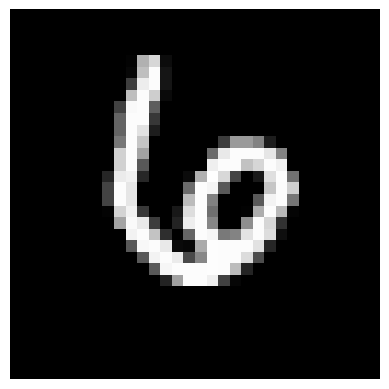

In [151]:
display_image(next(iter(train_data_loader))[0][0])

- Function to display Train and Test losses

In [152]:
def display_loss(train_loss, test_loss):

    plt.figure(figsize=(5,5))
    
    plt.plot(np.arange(1,len(train_loss)+1,1), train_loss, label='Train Loss')
    plt.plot(np.arange(1,len(test_loss)+1,1), test_loss, label='Test Loss')

    plt.legend()

- Function to display n original vs decoded images from a trained model 

In [153]:
def display_decoded_images(model, n_images=5):

    train_images_sample = next(iter(test_data_loader))[0][0:n_images].detach()
    
   
    
    for n, test_image in enumerate(train_images_sample):
        
        plt.figure(figsize=(5, 20))
        
        plt.subplot(n_images,2,2*n+1)
        display_image(test_image)
        model.eval()
        with torch.no_grad():      
            test_image = test_image.to(device=device)
            
            sig = nn.Sigmoid()
            decoded_image = sig(model(test_image.reshape(1,1,image_size,image_size)).cpu().reshape(1,image_size,image_size))
            
        plt.subplot(n_images,2,2*n+2)
        
        display_image(decoded_image)  
    
    plt.show()

In [154]:
train_images_sample = next(iter(train_data_loader))[0][0:500]
test_images_sample = next(iter(test_data_loader))[0][0:500]

# Define Learning Function & Custom Loss Function

Here we define our custom loss function that combines the BCE reconstruction loss with the KL divergence.

The Reconstruction loss is standard for an autoencoder and measures how close the decoded image is from the original image, usually using MSE or BSE loss.

The KL Divergence loss is used on the latent space of an Autoencoder to enforce the latent space to have continuity and completeness.
- Continuity - points in the latent space close to each other should be similar, i.e. in our use case the same number, or numbers with similar shapes, should be close to each other in the latent space.
- Completeness - all points in the latent space should represent a sample from the dataset, so sampled points in the latent space should decode to a meaningful image. In our case this means when sampling from across the latent space, all images should be recognisable as digits but with slightly different properties.

A Variational Autoencoder (VAE) is unqiue in that, rather than outputting single values for the n dimensions in it's latent space, it outputs a mean and standard deviation for each dimension. For each dimension, a single point is then randomly sampled from, in our case, a gaussian distribution with the given mean and std, and this is then fed into the decoder. This helps to create a more continuous latent space as an input can be encoded into a range of similar output values. It also creates a more compelete latent space by spreading out the latent space representations for each image.

The way that the KL Divergence is enforced on the VAE's latent space is to constrain the gassian sampled points in the latent space across a batch to be close to a mean of 0 and a standard deviation of 1. The calculation for the KL Loss is taken from the below paper, and works when the prior and posterior approximations are assumed to be Gaussian.

https://arxiv.org/pdf/1312.6114v10

Another form of the KL Divergance for the Gaussian case exists where the model outputs log(variance) rather than the standard deviation, and this help with stability during training, but for out simpler dataset, and for better understanding of the maths, I have used the standard deviation version.

In [155]:
bce_loss = nn.BCEWithLogitsLoss(reduction='mean')

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x_pred, x, latent_space, kl_lambda=1):

        self.reconstruction_loss = bce_loss(x_pred, x)
    
        mean_latent = latent_space.mean(axis=0)
        std_latent = latent_space.std(axis=0)
    
        self.kl_loss = - 0.5 * torch.sum(1 + torch.log(std_latent**2) - mean_latent**2 - std_latent**2)
        
        return self.reconstruction_loss + self.kl_loss * kl_lambda

We define a learning function that keep track of the total loss (which is used in backpropagation), and the KL divergence loss and reconstructionn loss separately. From this we can better underdtand the performance of the model, and and tweak the KL loss lambda if required (a value of 1 performs well).

In [156]:
def train_model(n_epochs, model, output_frequency=10):
    
    start = time.time()
    
    for epoch in range(n_epochs):
        
        batch_train_losses = []
        batch_test_losses = []
        
        batch_kl_train_losses = []
        batch_kl_test_losses = []
        
        batch_reconstruction_train_losses = []
        batch_reconstruction_test_losses = []

        train_count = 0
        test_count = 0
    
        model.train()

        for x, _ in train_data_loader:
    
            x = x.to(device=device)
          
            x_pred = model(x)
            
            optimizer.zero_grad()
            
            loss = criterion(x_pred, x, model.latent_space)
            
            loss.backward()
    
            optimizer.step()

            batch_train_losses.append(loss.item()*len(x))
            batch_kl_train_losses.append(criterion.kl_loss.item()*len(x))
            batch_reconstruction_train_losses.append(criterion.reconstruction_loss.item()*len(x))
            
            train_count += len(x.cpu())
            
        model.eval()
        
        with torch.no_grad():

            train_losses.append(np.sum(batch_train_losses)/train_count)
            kl_train_losses.append(np.sum(batch_kl_train_losses)/train_count)
            reconstruction_train_losses.append(np.sum(batch_reconstruction_train_losses)/train_count)
            
            for x, _ in test_data_loader:     

                x = x.to(device=device)
                
                x_pred = model(x)

                loss = criterion(x_pred, x, model.latent_space)
                
                batch_test_losses.append(loss.item()*len(x))
                batch_kl_test_losses.append(criterion.kl_loss.item()*len(x))
                batch_reconstruction_test_losses.append(criterion.reconstruction_loss.item()*len(x))
                
                test_count += len(x)
        
            test_losses.append(np.sum(batch_test_losses)/test_count)
            kl_test_losses.append(np.sum(batch_kl_test_losses)/test_count)
            reconstruction_test_losses.append(np.sum(batch_reconstruction_test_losses)/test_count)
            
        end = time.time()
    
        if (epoch+1) % (output_frequency) == 0:
            print(f'Ran epoch {epoch+1} in {int(end - start)} seconds with training loss {train_losses[-1]:.3f} and testing loss {test_losses[-1]:.3f}')

        start = time.time()    

    return model

# Create the Variational Autoencoder 

We have defined our Variational Autoencoder model below using Pytorch.

The encoder, the part of the model that encodes inputs into the latent space, is comprised of 3 convolutional layers and a linear layer. The exact properties of the layers can be defined as inputs into the model class. The encoder outputs 2n points representing the mean and standard deviation used to gaussian sample points in the n dimensional latent space. The method for gaussian sampling uses the "Reparameterization Trick", as described in https://arxiv.org/pdf/1312.6114v10. This allows backpropergation to flow through the network by first sampling from a gaussian distribution with mean 0 and std 1, and then multiplying by the latent space's std and adding the mean. These latter opperations are differentiable and so the model can learn. 

The decoder then takes the n dimensions of the latent space and attempts to reconstruct the original image. The architecture of the decoder is opposite to the encoder, a linear layer then 3 transposed convolutional layers to increase the image dimensions back to the original size.

In [157]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, layers, image_dim, image_channels, layer_1_channels, layer_2_channels, layer_3_channels, latent_layer_output, device=torch.device('cpu')):

        super().__init__()
        
        self.encoder_conv_dim = int(self.kernal_output_size(layers, image_dim, kernal_size=3, padding=1, stride=2))  
        self.flatten_dim = int(self.encoder_conv_dim ** 2 * layer_3_channels)   
        self.latent_layer_output = latent_layer_output
        self.device = device
        
        # Encoder
        self.encoder_sequential = nn.Sequential(
            self.conv_layer_block(image_channels, layer_1_channels, kernel_size=3, padding=1, stride=2, encoder=True)
            ,self.conv_layer_block(layer_1_channels, layer_2_channels, kernel_size=3, padding=1, stride=2, encoder=True)
            ,self.conv_layer_block(layer_2_channels, layer_3_channels, kernel_size=3, padding=1, stride=2, encoder=True)

            ,nn.Flatten()
            ,nn.Sequential(
                    nn.Linear(self.flatten_dim, 2*latent_layer_output)
                    ,torch.nn.BatchNorm1d(2*latent_layer_output)
            )
        )

        # Decoder
        self.decoder_sequential = nn.Sequential(
            nn.Sequential(
                    nn.Linear(latent_layer_output, self.flatten_dim)
                     ,torch.nn.BatchNorm1d(self.flatten_dim)
            )
            ,nn.Unflatten(1, (layer_3_channels, self.encoder_conv_dim ,self.encoder_conv_dim))
            
            ,self.conv_layer_block(layer_3_channels, layer_2_channels, kernel_size=3, padding=1, stride=2, encoder=False)
            ,self.conv_layer_block(layer_2_channels, layer_1_channels, kernel_size=3, padding=1, stride=2, encoder=False)
            
            ,nn.Sequential(
                nn.ConvTranspose2d(layer_1_channels, image_channels, kernel_size=3, stride=2, padding=1, output_padding = 1),
            )
        )
        
    # used to construct the convolutional layers using a standard form of conv layer, batch norm and relu
    def conv_layer_block(self, in_channels, out_channels, kernel_size, padding=1, stride=2, encoder=True):
        if encoder:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                torch.nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding = 1),
                torch.nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            )

    # recursive function used to calculate the output kernal size for a conv layer so that we can calculate the dimension of the linear layer
    def kernal_output_size(self, layers, input_size, kernal_size, padding, stride):
        output_size = np.floor((input_size - kernal_size + 2 * padding)/ stride)+1
        layers -= 1  
        if layers > 0:
            output_size = self.kernal_output_size(layers, output_size, kernal_size, padding, stride)
        return output_size

    def gaussian_sample(self, x):       
        gaus_sample = torch.tensor(np.random.normal(loc=0, scale=1, size=self.latent_layer_output)
                             ,dtype=torch.float).to(self.device)
        x = x.view(-1, 2, self.latent_layer_output)
        return x[:,0] * gaus_sample + x[:,1]

            
    def encoder(self, x):      
        x = self.encoder_sequential(x)
        x = self.gaussian_sample(x)
        return x

    def decoder(self, x):      
        x = self.decoder_sequential(x)
        return x
        
    def forward(self, x):
        x = self.encoder(x)
        self.latent_space = x
        x = self.decoder(x)
        return x

# Train Model


Model parameters are defined below. I have chosen a dimension of 5 for the latent space as this allows the model to encode enough information to accurately reconstuct the images. I originally experimented with 2 dimensions for ease of visualisation, but the performance of 5 was much better. We later use dimensionality reduction methods (PCA, UMAP & T-SNE) to help us visualise the latent space.

In [158]:
layers = 3
layer_1_channels = 16
layer_2_channels = 32
layer_3_channels = 64
latent_layer_output = 5

In [159]:
VAE_conv_model = VariationalAutoencoder(layers
                                             ,image_size
                                             ,image_channels
                                             ,layer_1_channels
                                             ,layer_2_channels
                                             ,layer_3_channels
                                             ,latent_layer_output
                                             ,device
                                            ).to(device)

In [160]:
summary(VAE_conv_model, input_size=(1, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
      BatchNorm1d-12                   [-1, 10]              20
           Linear-13                 [-1, 1024]           6,144
      BatchNorm1d-14                 [-

In [161]:
learning_rate = 0.001

criterion  = CustomLoss()

optimizer = torch.optim.Adam(VAE_conv_model.parameters()
                        ,lr=learning_rate
                        )

In [162]:
train_losses = []
test_losses = []

kl_train_losses = []
kl_test_losses = []

reconstruction_train_losses = []
reconstruction_test_losses = []

VAE_conv_model = train_model(n_epochs=50, model=VAE_conv_model, output_frequency=5)

Ran epoch 5 in 9 seconds with training loss 0.763 and testing loss 0.982
Ran epoch 10 in 10 seconds with training loss 0.394 and testing loss 0.303
Ran epoch 15 in 9 seconds with training loss 0.248 and testing loss 0.218
Ran epoch 20 in 9 seconds with training loss 0.172 and testing loss 0.156
Ran epoch 25 in 10 seconds with training loss 0.142 and testing loss 0.195
Ran epoch 30 in 10 seconds with training loss 0.131 and testing loss 0.135
Ran epoch 35 in 9 seconds with training loss 0.122 and testing loss 0.145
Ran epoch 40 in 9 seconds with training loss 0.118 and testing loss 0.128
Ran epoch 45 in 9 seconds with training loss 0.115 and testing loss 0.122
Ran epoch 50 in 9 seconds with training loss 0.113 and testing loss 0.119


# View Model Results

The model is able to minimise both BCE loss and the KL Divergence, with improvements plateuing around epoch 50.

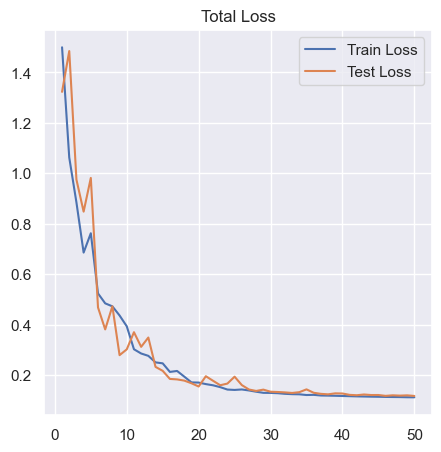

In [163]:
display_loss(train_losses, test_losses)
plt.title('Total Loss')
plt.show()

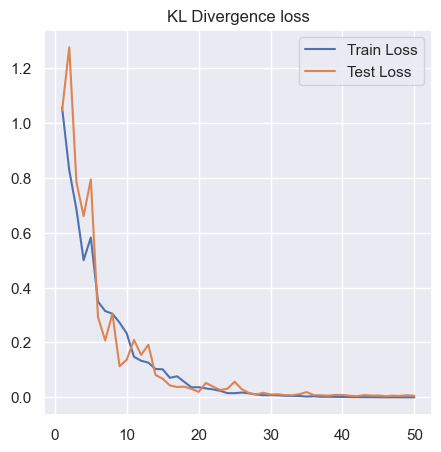

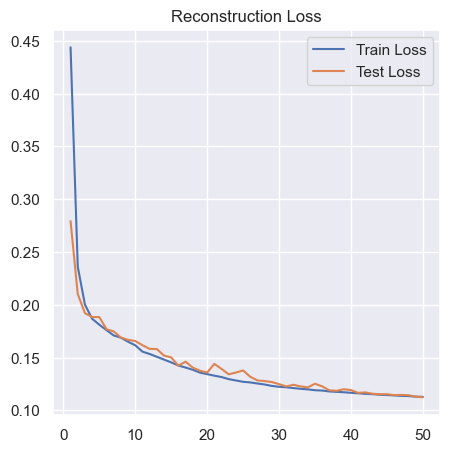

In [164]:
display_loss(kl_train_losses, kl_test_losses)
plt.title('KL Divergence loss')
plt.show()
display_loss(reconstruction_train_losses, reconstruction_test_losses)
plt.title('Reconstruction Loss')
plt.show()


Below you can see the original image (left) vs the model's re-constructed image (right).

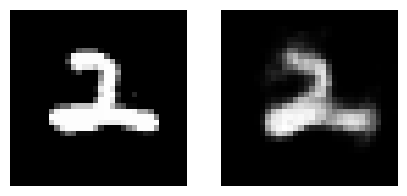

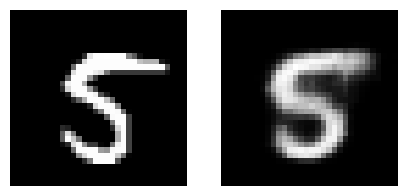

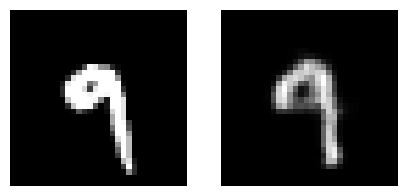

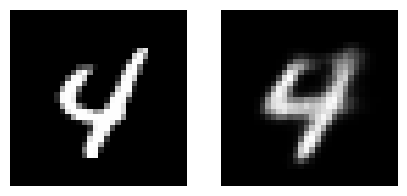

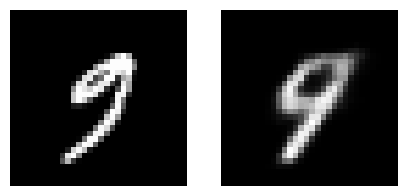

In [165]:
display_decoded_images(VAE_conv_model, n_images=5)

# Investigate Latent Space Sampling

Next I will investigate latent space sampling. This involves picking points in the model's latent space and running them through the models decoder to generate new images. Through this we can see how the latent space of the model is structed and how different regions of the latent space encode different properties.

To do this I have encoded a batch of test set images and used PCA to find the best 2 dimensional representation for each of the digits (0-9) from their 5D latent space representations. From the PCA representation, I then sampled a grid of points, which were then reverse PCA transformed into their respective latent space representation. These were run through our VAE's decoder and the resulting images were plotted on a grid alongside our original PCA test set samples to view how the properties of each digit vary across the most variant vectors in it's latent space. 

In [166]:
# sample and encode test set images
images, labels = next(iter(test_data_loader))

images = images.to(device=device)
labels = labels

VAE_conv_model.eval()

with torch.no_grad():

    latent_representation = VAE_conv_model.encoder(images).cpu()

The below functions allow us to run our sampling method by, for each digit:
1. Fitting a 2D PCA model to a sample of encoded images
2. Sampling a meshgrid of points from within this PCA space and inverse PCA transforming to their latent space representation
3. Decoding the latent space representations
4. Plotting the original PCA transformed test set co-ordinates alongside a grid of the decoded PCA sampled images at their original PCA co-ordinates

In [167]:
# fit 2 PCA components for a given label
def pca_components(latent_sample, labels, label):

    latent_sample_subset = latent_sample[labels==label].numpy()

    pca_model = PCA(n_components=2)

    latent_sample_pca = pca_model.fit_transform(latent_sample_subset)
    
    return pca_model, latent_sample_pca

# sample across the 2D space and inverse transform back to latent space representation
def pca_space_sampler(pca_model, latent_sample_pca, x_lims, y_lims, sample_dim):

    pca_sample_x = np.linspace(x_lims[0], x_lims[1], sample_dim+2)[1:-1]
    pca_sample_y = np.linspace(y_lims[0], y_lims[1], sample_dim+2)[1:-1]
    
    pca_space_coords = np.array(np.meshgrid(pca_sample_x, pca_sample_y)).T.reshape(-1,2)

    pca_space_inverse = pca_model.inverse_transform(pca_space_coords)

    return pca_space_coords, pca_space_inverse
    
# decode the latent space representations using our trained model
def decode_inverse_pca_sample(model, pca_space_inverse):

    latent_space_sample = torch.tensor(pca_space_inverse, dtype=torch.float32).to(device)

    sig = nn.Sigmoid()
    
    decoded_samples = sig(model.decoder(latent_space_sample)).cpu().detach().numpy()

    return decoded_samples

# plot the results of our PCA space and grid of sampled images
def plot_pca_sampled_images(ax, pca_space_coords, decoded_samples, sample_dim):

    pca_space_spacing_x = pca_space_coords[sample_dim+1,0]-pca_space_coords[0,0]
    pca_space_spacing_y = pca_space_coords[1,1]-pca_space_coords[0,1]

    ax.grid('on')

    for coord, decoded_sample in zip(pca_space_coords, decoded_samples):

        ax.imshow(decoded_sample.reshape(32,32)
                  ,extent=[coord[0]-0.5*pca_space_spacing_x,coord[0]+0.5*pca_space_spacing_x
                           ,coord[1]-0.5*pca_space_spacing_y,coord[1]+0.5*pca_space_spacing_y]
                 )

In [168]:
def latent_space_sampler(latent_representation, labels, sample_dim=6):

    pca_models = []
    
    for label in np.arange(0,10,1):

        pca_model, latent_sample_pca = pca_components(latent_representation, labels, label)
        pca_models.append([label, pca_model])
        
        fig, axs = plt.subplots(1,2, figsize=(14, 6))
        fig.suptitle(f'Latent Space Sampling for Label {label}')
        axs[0].scatter(latent_sample_pca[:,0], latent_sample_pca[:,1])
        axs[0].set_title('PCA 2D Projection of Latent Space')
        x_lims = axs[0].get_xlim()
        y_lims = axs[0].get_ylim()
    
        pca_space_coords, pca_space_inverse = pca_space_sampler(pca_model, latent_sample_pca, x_lims, y_lims, sample_dim=sample_dim)
    
        decoded_samples = decode_inverse_pca_sample(VAE_conv_model, pca_space_inverse)
         
        plot_pca_sampled_images(axs[1] ,pca_space_coords, decoded_samples, sample_dim)
    
        axs[1].set_xlim(x_lims)
        axs[1].set_ylim(y_lims)
        axs[1].set_aspect('auto')
        axs[1].set_title('Decoded Images Sampled from 2D PCA Projected Latent Space')
        
        plt.show()
    
        print(f'The two strongest Principle Components for label {label} account for {pca_model.explained_variance_ratio_.sum():.1%} of the explained variance.')

    return pca_models

Below we can see the generated images per digit. From this we can begin to understand how the latent space is structured for our 

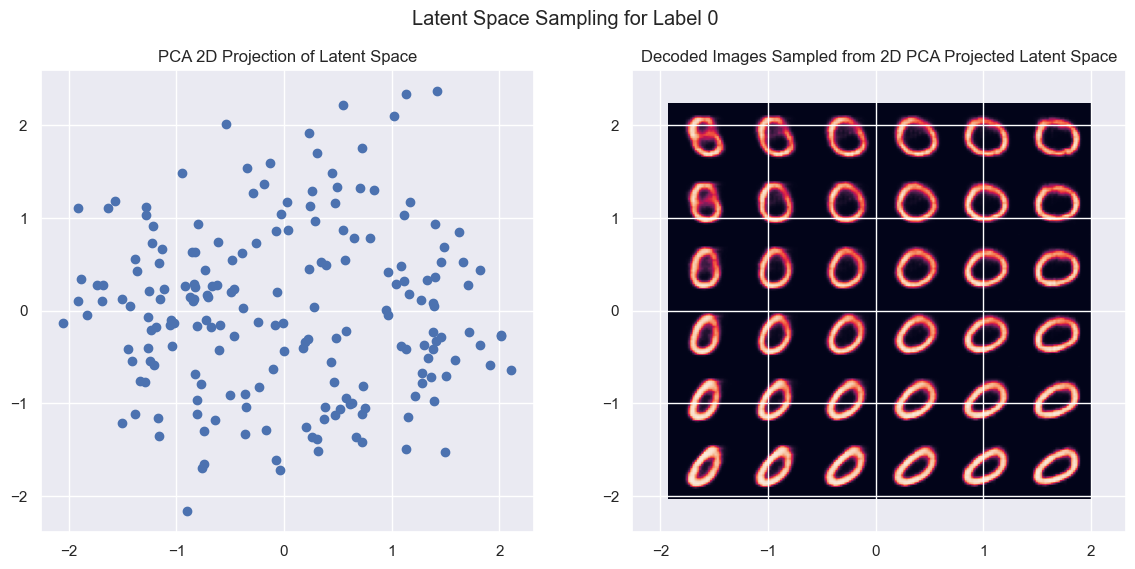

The two strongest Principle Components for label 0 account for 74.4% of the explained variance.


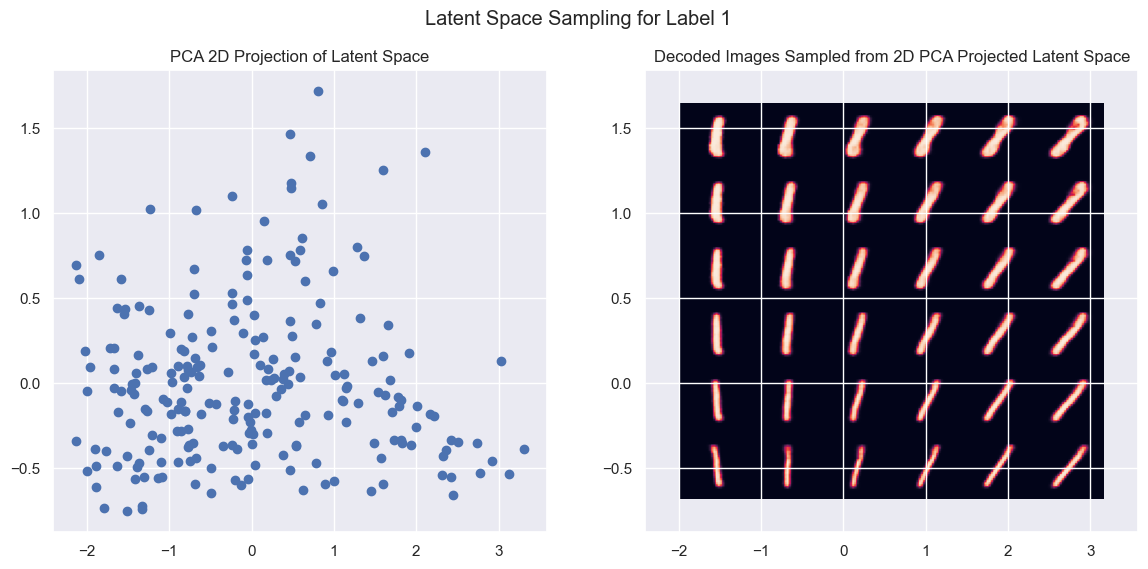

The two strongest Principle Components for label 1 account for 89.5% of the explained variance.


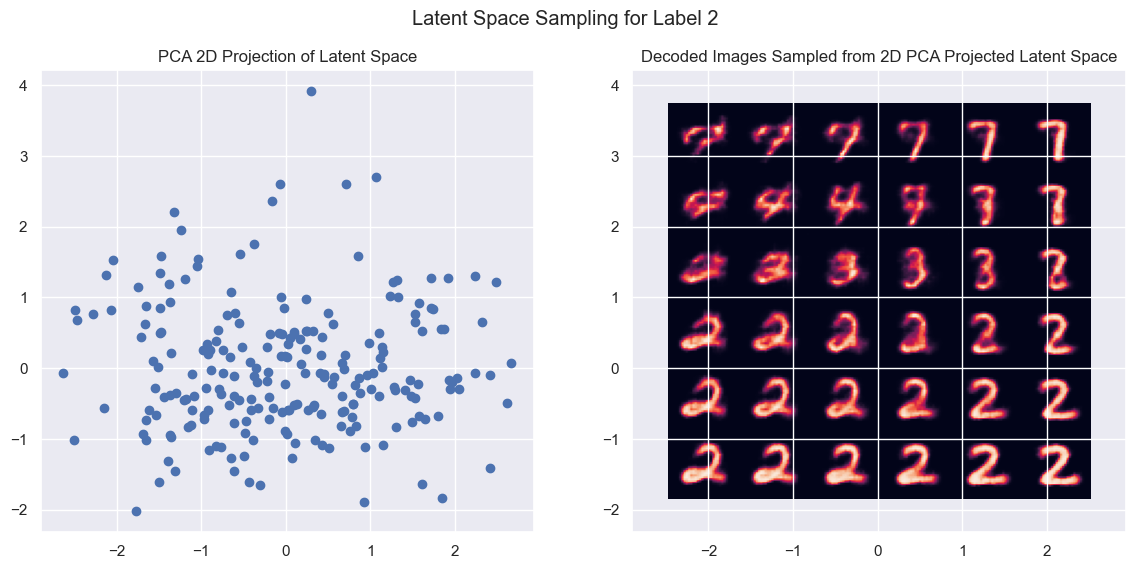

The two strongest Principle Components for label 2 account for 65.9% of the explained variance.


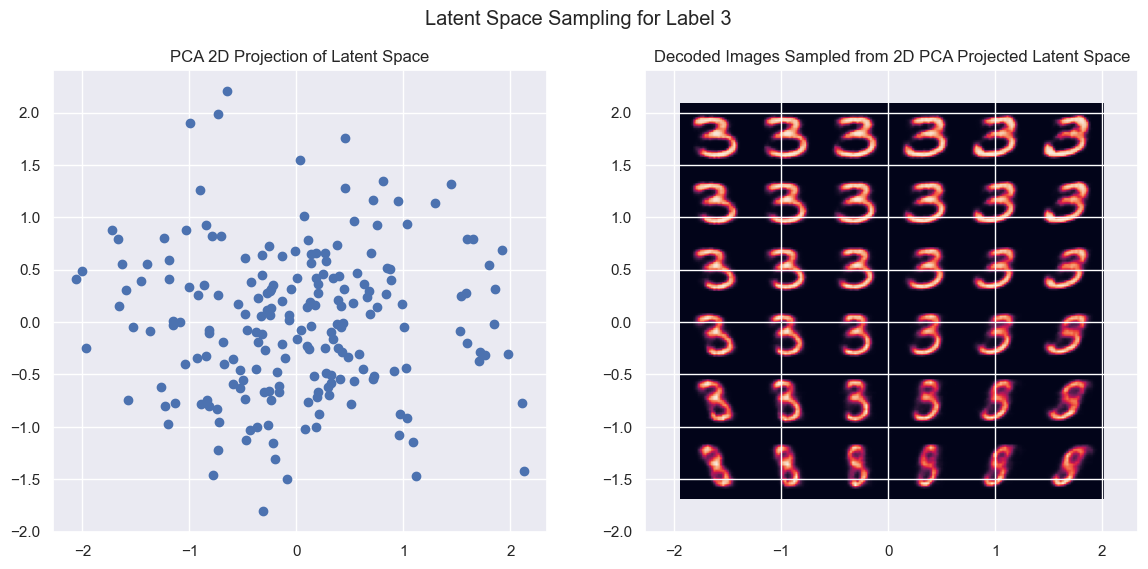

The two strongest Principle Components for label 3 account for 67.8% of the explained variance.


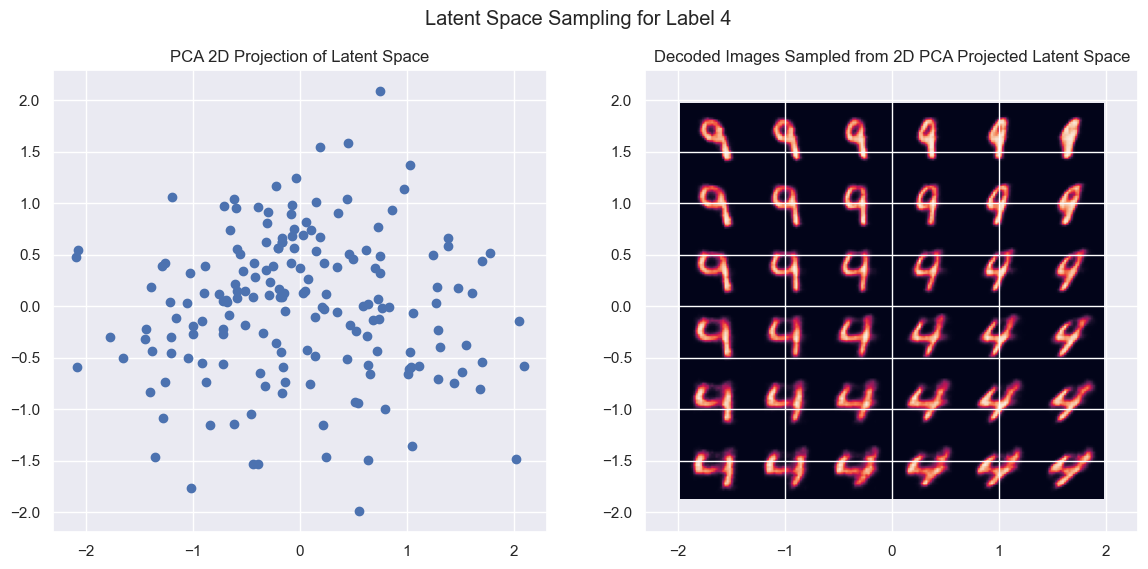

The two strongest Principle Components for label 4 account for 70.9% of the explained variance.


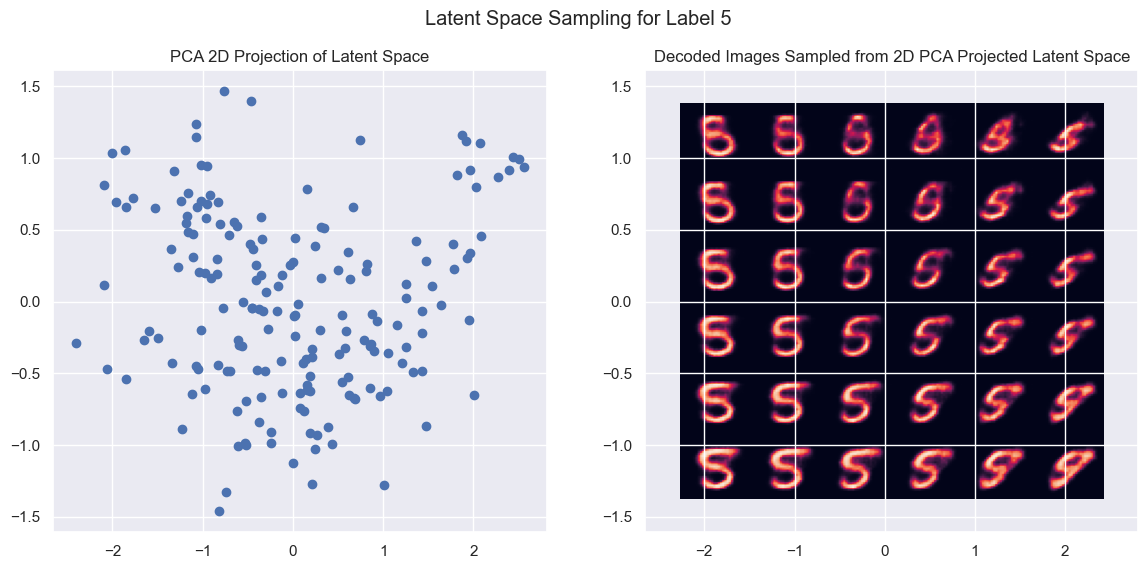

The two strongest Principle Components for label 5 account for 70.2% of the explained variance.


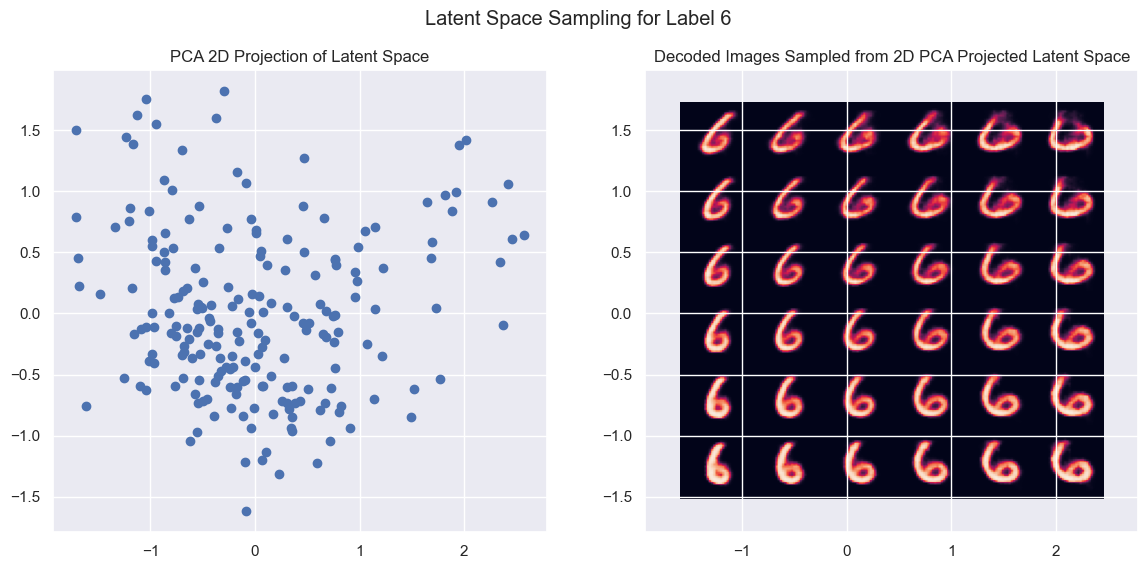

The two strongest Principle Components for label 6 account for 67.0% of the explained variance.


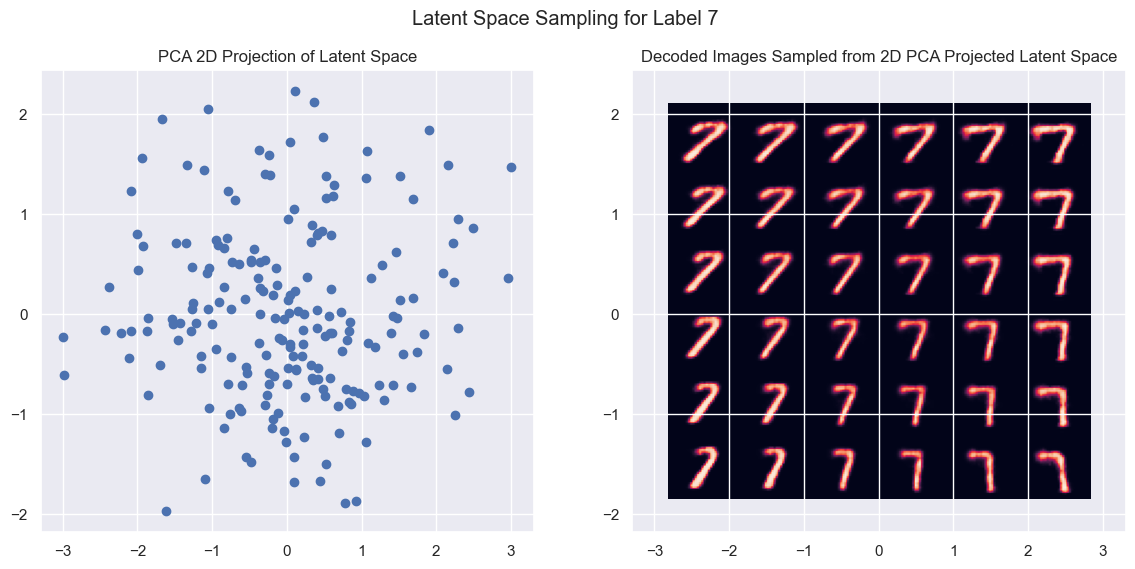

The two strongest Principle Components for label 7 account for 71.2% of the explained variance.


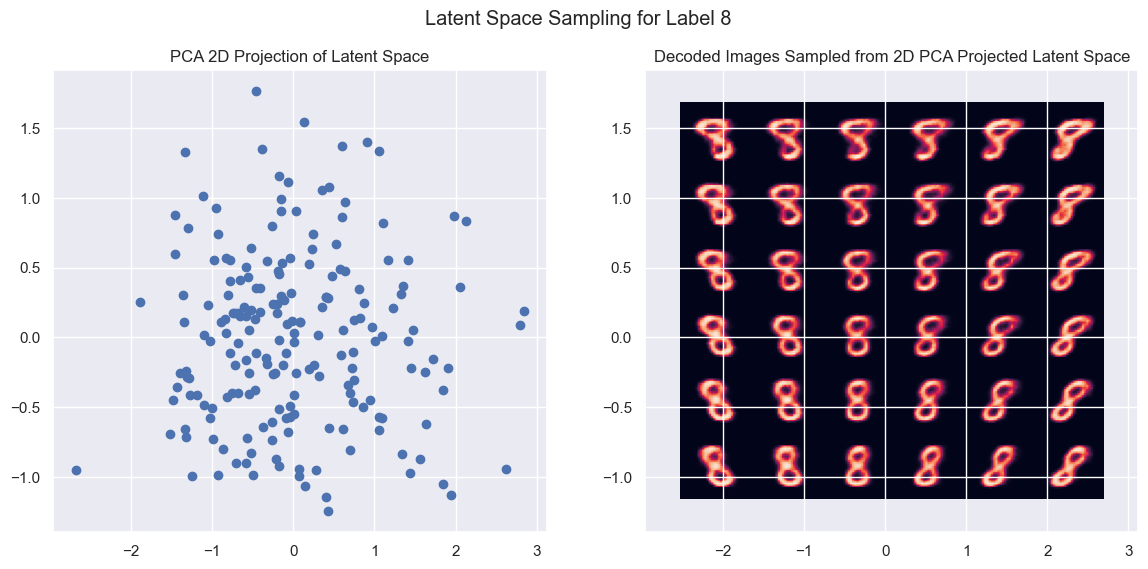

The two strongest Principle Components for label 8 account for 67.8% of the explained variance.


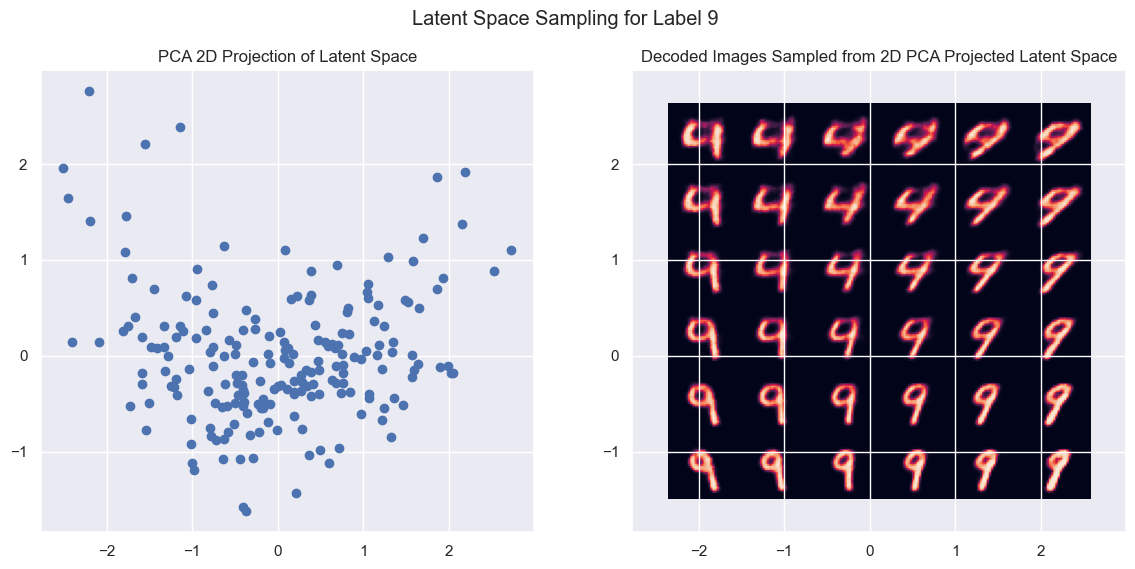

The two strongest Principle Components for label 9 account for 75.5% of the explained variance.


In [173]:
pca_models = latent_space_sampler(latent_representation, labels, 6)

## Viewing the Similarity Between Digit's PCA Vectors

In [196]:
def pca_similarirty (pca_models):
    
    pca_similarities = np.zeros((10,10))
    
    for i in range(10):
        for j in range(10):
    
            pca_vector_i_0 = pca_models[i][1].components_[0]
            pca_vector_j_0 = pca_models[j][1].components_[0]
            pca_vector_i_1 = pca_models[i][1].components_[1]
            pca_vector_j_1 = pca_models[j][1].components_[1]
    
            pca_similarity_0_0 = abs(1 - cosine(pca_vector_i_0, pca_vector_j_0))
            pca_similarity_0_1 = abs(1 - cosine(pca_vector_i_0, pca_vector_j_1))
            pca_similarity_1_0 = abs(1 - cosine(pca_vector_i_1, pca_vector_j_0))
            pca_similarity_1_1 = abs(1 - cosine(pca_vector_i_1, pca_vector_j_1))
    
            pca_similarity_max = np.max([pca_similarity_0_0
                                         ,pca_similarity_0_1
                                         ,pca_similarity_1_0
                                         ,pca_similarity_1_1])
    
            pca_similarities[i,j] = pca_similarity_max

    pca_similarities_df = pd.DataFrame(pca_similarities, columns = np.arange(0,10), index=np.arange(0,10))

    sns.heatmap(df, annot=True, fmt=".2f")
    plt.title('Maximum Cosine Similarity Between Pairs of Digit\'s PCA Vectors')
    plt.show()

    return pca_similarities_df
    

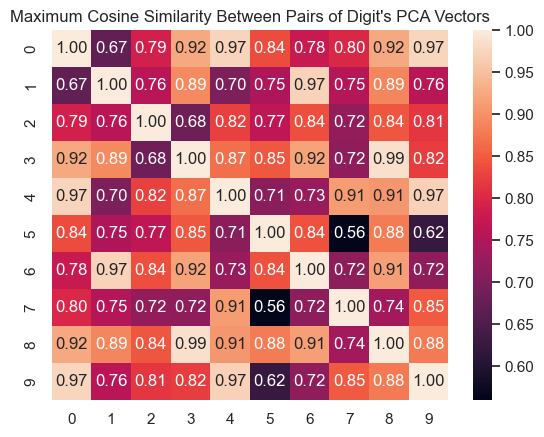

In [197]:
df = pca_similarirty (pca_models)

# View 2D Latent Space Projections

In [257]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)

In [258]:
proj_2d = umap_2d.fit_transform(latent_representation)

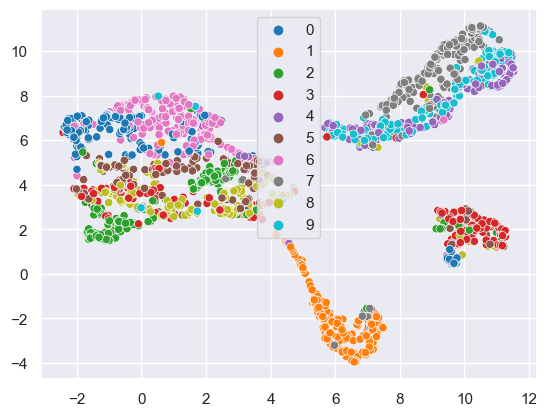

In [259]:
sns.scatterplot(x=proj_2d[:,0], y=proj_2d[:,1], hue=labels, palette=sns.color_palette('tab10'))

plt.show()

In [260]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(latent_representation)


<Axes: >

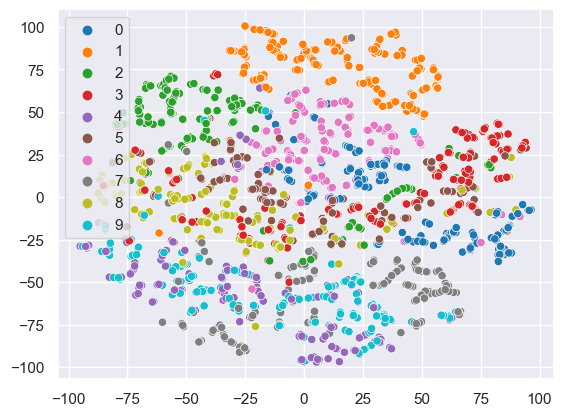

In [261]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels, palette=sns.color_palette('tab10'))